# Prediction Results of DIKU with freezed DKU weights to reproduce Fig. 2

In [8]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
DKO_DIR = Path('__file__').absolute().parent
import random
import sys
sys.path.append(str(DKO_DIR / "train"))
import pickle
from sklearn import preprocessing
from controllers import OpenLoopController
from Utility import data_collecter
from dynamics import LinearLiftedDynamics

In [9]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

Methods = ["KoopmanIU", "KoopmanU"]
Method_names = ["DIKU", "DKU"]

In [10]:
def evaluate_ol_pred(sys, xs, t_eval, us=None, n_eval_states=None):
    n_traj = xs.shape[0]
    traj_length = xs.shape[1]
    n = xs.shape[2]
    if n_eval_states is None:
        n_eval_states = n

    if us is not None:
        us_scaled = us.copy()
    xs_pred = np.empty((n_traj, traj_length - 1, n_eval_states))
    xs_prev = np.empty((n_traj, traj_length - 1, n_eval_states))
    for ii in range(n_traj):
        if sys.standardizer_u is not None:
            us_scaled[ii, :, :] = sys.standardizer_u.transform(us[ii, :, :])
        ctrl = OpenLoopController(sys, us_scaled[ii, :, :], t_eval[ii, :-1])

        x0 = xs[ii, 0, :]
        z0 = sys.basis(np.atleast_2d(x0)).squeeze()
        zs_tmp, _ = sys.simulate(z0, ctrl, t_eval[ii, :-1])
        xs_pred[ii, :, :] = np.dot(sys.C, zs_tmp.T).T

        xT = xs[ii, -1, :]
        zT = sys.basis(np.atleast_2d(xT)).squeeze()
        zs_prev, _ = sys.inverse_simulate(zT, ctrl, t_eval[ii, :-1])
        xs_prev[ii, :, :] = np.dot(sys.C, zs_prev.T).T

        if sys.standardizer_x is not None:
            if n_eval_states is not None:
                standardizer_x = preprocessing.StandardScaler()
                standardizer_x.n_features_in_ = n_eval_states
                standardizer_x.scale_ = sys.standardizer_x.scale_[:n_eval_states]
                standardizer_x.var_ = sys.standardizer_x.var_[:n_eval_states]
                standardizer_x.mean_ = sys.standardizer_x.mean_[:n_eval_states]
            else:
                standardizer_x = sys.standardizer_x

            xs_pred[ii, :, :] = standardizer_x.inverse_transform(xs_pred[ii, :, :])
            xs_prev[ii, :, :] = standardizer_x.inverse_transform(xs_prev[ii, :, :])
            if sys.standardizer_x.with_mean:
                xs_pred[ii, :, : int(n / 2)] += np.multiply(
                    t_eval[ii, :-1],
                    sys.standardizer_x.mean_[int(n / 2):].reshape(-1, 1),
                ).T
                xs_prev[ii, :, : int(n / 2)] += np.multiply(
                    t_eval[ii, :-1],
                    sys.standardizer_x.mean_[int(n / 2):].reshape(-1, 1),
                ).T

    error = xs[:, :-1, : xs_pred.shape[2]] - xs_pred
    max_loss = np.mean(np.max(np.abs(error), axis=0), axis=1)
    mean_loss = np.mean(np.mean(np.abs(error), axis=0), axis=1)

    error1 = xs[:, 1:, : xs_prev.shape[2]] - xs_prev
    max_inv_loss = np.mean(np.max(np.abs(error1), axis=0), axis=1)
    mean_inv_loss = np.mean(np.mean(np.abs(error1), axis=0), axis=1)

    return max_loss, mean_loss, max_inv_loss, mean_inv_loss


In [11]:
# Predictive and Previous states Err
def eval_prev_err(suffix, env_name, method_index):
    # method_index = 0
    method = Methods[method_index]
    root_path = str(DKO_DIR / "Data" / suffix)
    print(method, env_name)
    for file in os.listdir(root_path):
        if file.startswith(method + "_" + env_name) and file.endswith(".pth"):
            model_path = file
    Data_collect = data_collecter(env_name)
    udim = Data_collect.udim
    Nstate = Data_collect.Nstates
    dicts = torch.load(root_path + "/" + model_path, map_location=torch.device("cpu"))
    state_dict = dicts["model"]
    device = torch.device("cpu")
    if (env_name == "PlanarQuadrotor"):
        from train.DIKU_quad import KoopDnn as lka
        if method.endswith("KoopmanU"):
            from train.koopman_net_U import KoopmanNetCtrl as KNC
            with open(str(DKO_DIR /"train/parameters.pickle"), "rb") as handle:
                net_para = pickle.load(handle)
            loss_scaler = dicts["loss_scaler"]
            konet = KNC(net_para)
            konet.device = device
            konet.construct_net()
            konet.load_state_dict(state_dict)
            konet.loss_scaler_x = loss_scaler[0]
            konet.loss_scaler_z = loss_scaler[1]
        elif method.endswith("KoopmanIU"):
            from train.koopman_net_IU import KoopmanNetInvCtrl as KNC
            print(dicts["Ilayer"],dicts["INNconfig"])
            with open(str(DKO_DIR /"train/parameters_IU.pickle"), "rb") as handle:
                net_para = pickle.load(handle)
            loss_scaler = dicts["loss_scaler"]
            konet = KNC(net_para)
            konet.device = device
            konet.masks = dicts["mask"]
            konet.inn_config = dicts["INNconfig"]
            konet.inn_layers = dicts["Ilayer"]
            konet.construct_net()
            konet.load_state_dict(state_dict)
            konet.loss_scaler_x = loss_scaler[0]
            konet.loss_scaler_z = loss_scaler[1]
        net = lka(konet)
        net.construct_koopman_model()
    elif method.endswith("KoopmanIU"):
        import Deepkoopman.train.DIKU as lka

        elayer = dicts["Elayer"]
        ilayer = dicts["Ilayer"]
        inn_config = dicts["INNconfig"]
        NKoopman = elayer[-1] + Nstate
        net = lka.Network(Nstate, udim, elayer, ilayer, inn_config,device)
        net.masks = dicts["mask"]
        net.construct_net()
        net.load_state_dict(state_dict)
        print(inn_config, ilayer)
    elif method.endswith("KoopmanU"):
        import Deepkoopman.train.DKU as lka

        layer = dicts["layer"]
        NKoopman = layer[-1] + Nstate
        net = lka.Network(layer, NKoopman, udim)
        net.load_state_dict(state_dict)

    Samples = 1000
    steps = 100
    random.seed(2023)
    np.random.seed(2023)
    times = 5
    max_loss_all = np.zeros((times, steps))
    mean_loss_all = np.zeros((times, steps))
    max_inv_loss_all = np.zeros((times, steps))
    mean_inv_loss_all = np.zeros((times, steps))
    with torch.no_grad():
        for i in range(times):
            test_data_path = str(DKO_DIR / "Data/{}{}.npy".format(env_name, i))
            if os.path.exists(test_data_path):
                test_data = np.load(test_data_path)
            else:
                print("No saved Data")
                test_data = Data_collect.collect_koopman_data(Samples, steps)
                np.save(test_data_path, test_data)
                print("Test Data saved")
            test_tensor = torch.from_numpy(test_data)
            if env_name == "PlanarQuadrotor" and method.endswith("KoopmanU"):
                ko_system = LinearLiftedDynamics(
                    net.A,
                    net.Ainv,
                    net.B,
                    np.array(net.C, dtype=float),
                    net.basis_encode,
                    continuous_mdl=False,
                    dt=Data_collect.dt,
                    standardizer_u=None,
                    bounds=Data_collect.bounds,
                )
                max_loss, mean_loss, max_inv_loss, mean_inv_loss = evaluate_ol_pred(
                    ko_system,
                    test_data[:, :, :Nstate],
                    np.tile(Data_collect.t_eval, (Samples, 1)),
                    us=test_data[:, :-1, Nstate:],
                )
            else:
                max_loss, mean_loss, max_inv_loss, mean_inv_loss = lka.K_fb_loss(test_tensor, net, Nstate, udim)
            max_loss_all[i] = max_loss.reshape(-1)
            mean_loss_all[i] = mean_loss.reshape(-1)
            max_inv_loss_all[i] = max_inv_loss.reshape(-1)
            mean_inv_loss_all[i] = mean_inv_loss.reshape(-1)
    max_mean = np.mean(max_loss_all, axis=0)
    max_std = np.std(max_loss_all, axis=0)
    mean_mean = np.mean(mean_loss_all, axis=0)
    mean_std = np.std(mean_loss_all, axis=0)
    max_inv_mean = np.mean(max_inv_loss_all, axis=0)
    max_inv_std = np.std(max_inv_loss_all, axis=0)
    mean_inv_mean = np.mean(mean_inv_loss_all, axis=0)
    mean_inv_std = np.std(mean_inv_loss_all, axis=0)
    np.save(
        "./Results/CompareData/" + suffix + "_" + method + ".npy",
        np.array(
            [
                max_mean,
                max_std,
                mean_mean,
                mean_std,
                max_inv_mean,
                max_inv_std,
                mean_inv_mean,
                mean_inv_std,
            ]
        ),
    )
    return (
        max_mean,
        max_std,
        mean_mean,
        mean_std,
        max_inv_mean,
        max_inv_std,
        mean_inv_mean,
        mean_inv_std,
    )

In [32]:
env_names = ["Linear2D","DampingPendulum", "Nonlinear3D","CartPole","TwoLinkRobot","PlanarQuadrotor"]
suffixes = ["Linear2D0614","DampingPendulum0614", "Nonlinear3D0614","CartPole0627", "TwoLinkRobot0614","Quad0614"]
for j in range(len(env_names)):
    for i in range(2):
        eval_prev_err(suffixes[j], env_names[j], method_index=i)

KoopmanIU Linear2D
[1, 1] {'tnsl_layers': [128, 64, 32], 'cmpd_layers': [128, 64, 32]}
KoopmanU Linear2D
KoopmanIU DampingPendulum
[1, 1] {'tnsl_layers': [128, 64, 32], 'cmpd_layers': [128, 64, 32]}
KoopmanU DampingPendulum
KoopmanIU Nonlinear3D
[1, 1] {'tnsl_layers': [128, 64, 32], 'cmpd_layers': [128, 64, 32]}
KoopmanU Nonlinear3D
KoopmanIU CartPole
[1, 1] {'tnsl_layers': [128, 64, 32], 'cmpd_layers': [128, 64, 32]}
KoopmanU CartPole
KoopmanIU TwoLinkRobot
[1, 1] {'tnsl_layers': [128, 64, 32], 'cmpd_layers': [128, 64, 32]}
KoopmanU TwoLinkRobot
KoopmanIU PlanarQuadrotor
{'tnsl_layers': [128, 64, 32], 'cmpd_layers': [128, 64, 32]} [1, 1]
KoopmanU PlanarQuadrotor


/tmp/ipykernel_2853787/511218530.py:44: RuntimeWarning: divide by zero encountered in log10
  np.log10(data[2]),
/tmp/ipykernel_2853787/511218530.py:51: RuntimeWarning: divide by zero encountered in log10
  np.log10(data[6]),


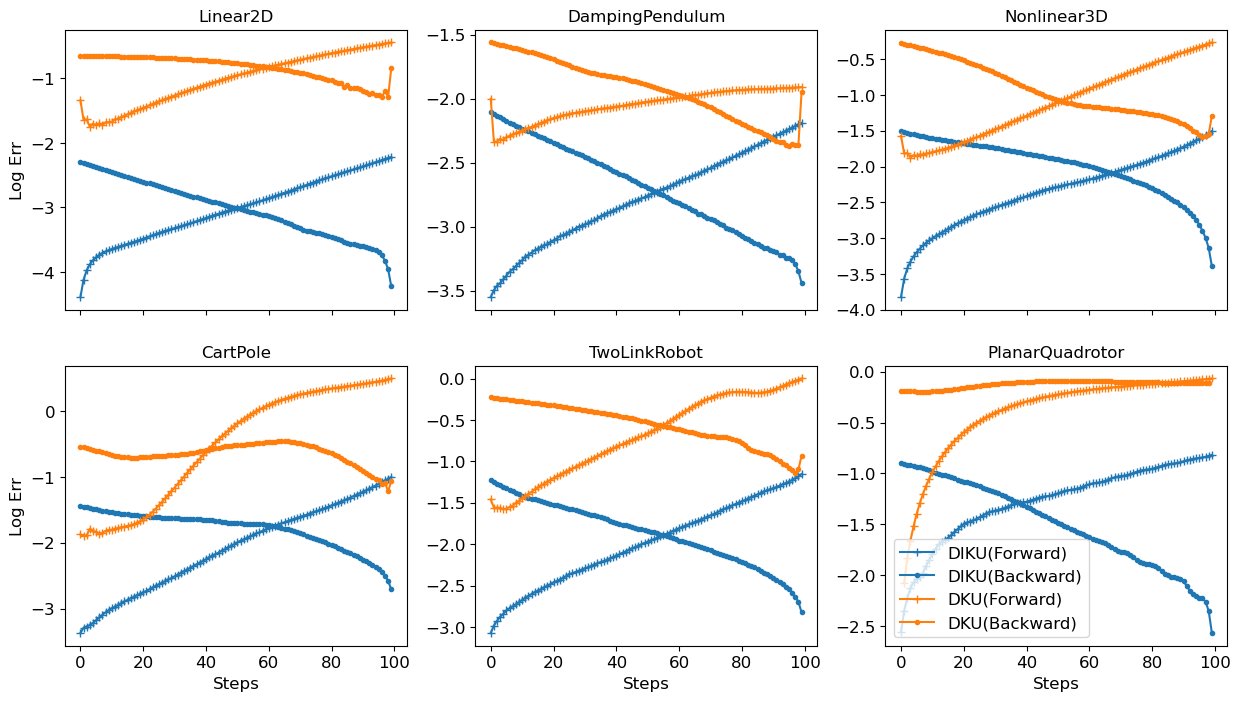

In [35]:
compare = "mean"
fig, axes = plt.subplots(2,3, figsize=(15,8), sharex=True)
colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]
font = {"size": 12}

plt.rc("font", **font)
# markers = ['*','+','*','+','*','+','*']
for j in range(6):
    ax = axes[j // 3, j % 3]
    # for j in range(len(env_names)):
    title = env_names[j]
    for i in range(2):
        method = Methods[i]
        file_path = "./Results/CompareData/" + suffixes[j] + "_" + method + ".npy"
        data = np.load(file_path)
        if compare.startswith("max"):
            ax.plot(
                np.log10(data[0]),
                "+-",
                color=colors[i],
                label=Method_names[i] + "(Forward)",
                linewidth=1.5,
            )
            ax.plot(
                np.log10(data[4]),
                ".-",
                color=colors[i],
                label=Method_names[i] + "(Backward)",
                linewidth=1.5,
            )
        else:
            ax.plot(
                np.log10(data[2]),
                "+-",
                linewidth=1.5,
                color=colors[i],
                label=Method_names[i] + "(Forward)",
            )  # predictive
            ax.plot(
                np.log10(data[6]),
                ".-",
                linewidth=1.5,
                color=colors[i],
                label=Method_names[i] + "(Backward)",
            )
        ax.set_title(title, fontsize=12)
        if title=="PlanarQuadrotor" or title=="TwoLinkRobot" or title=="CartPole":
            ax.set_xlabel("Steps", fontsize=12)
        if title=="Linear2D" or title=="CartPole":
            ax.set_ylabel("Log Err", fontsize=12)


plt.legend()
# plt.grid(linestyle='-.')
# plt.savefig("./Results/" + suffixes[j] + "_" + compare + ".png", dpi=300)
plt.savefig("./Results/all.png", dpi=600)
plt.show()

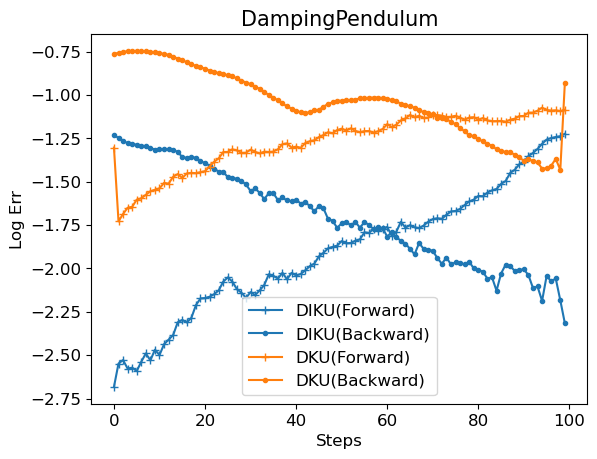

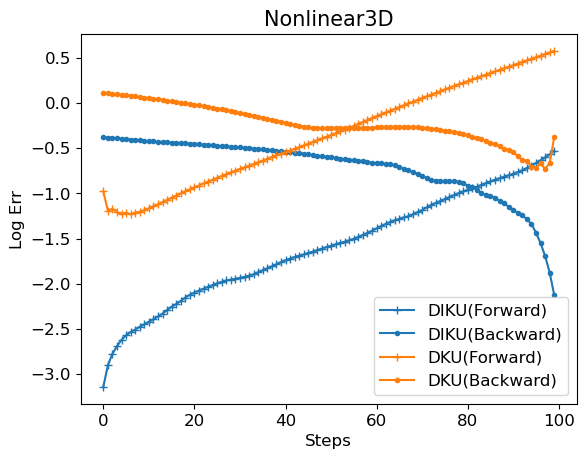

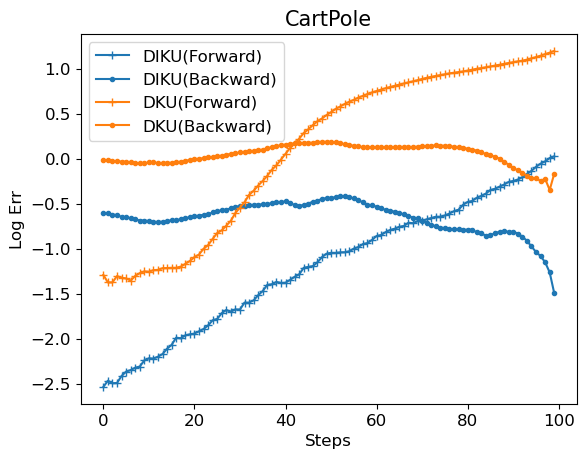

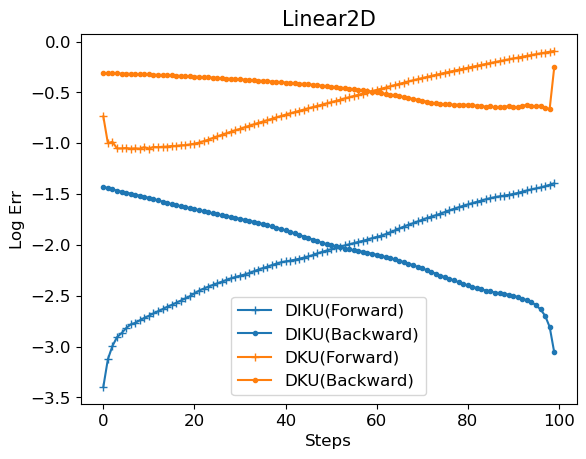

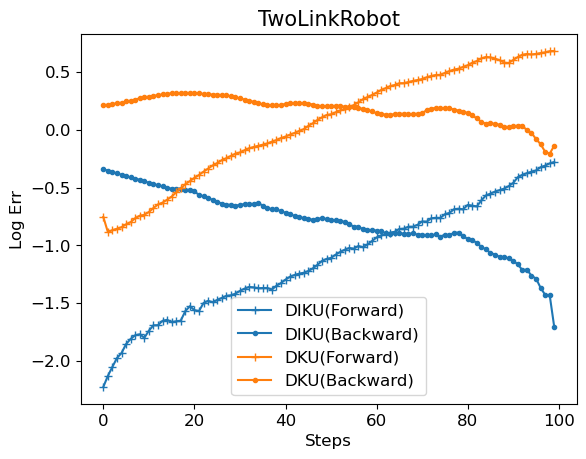

/tmp/ipykernel_2853787/3612236429.py:29: RuntimeWarning: divide by zero encountered in log10
  np.log10(data[0]),
/tmp/ipykernel_2853787/3612236429.py:36: RuntimeWarning: divide by zero encountered in log10
  np.log10(data[4]),


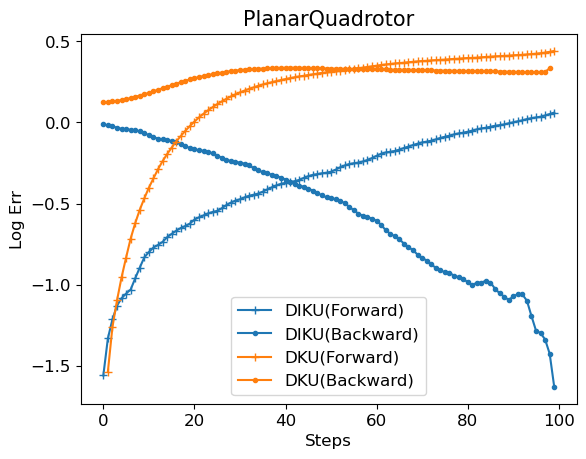

In [ ]:
compare = "max"


colors = [
    "#1f77b4",
    "#ff7f0e",
    "#2ca02c",
    "#d62728",
    "#9467bd",
    "#8c564b",
    "#e377c2",
    "#7f7f7f",
    "#bcbd22",
    "#17becf",
]
font = {"size": 12}

plt.rc("font", **font)
# markers = ['*','+','*','+','*','+','*']

for j in range(len(env_names)):
    title = env_names[j]
    for i in range(2):
        method = Methods[i]
        file_path = "./Results/CompareData/" + suffixes[j] + "_" + method + ".npy"
        data = np.load(file_path)
        if compare.startswith("max"):
            plt.plot(
                np.log10(data[0]),
                "+-",
                color=colors[i],
                label=Method_names[i] + "(Forward)",
                linewidth=1.5,
            )
            plt.plot(
                np.log10(data[4]),
                ".-",
                color=colors[i],
                label=Method_names[i] + "(Backward)",
                linewidth=1.5,
            )
        else:
            plt.plot(
                np.log10(data[2]),
                "+-",
                linewidth=1.5,
                color=colors[i],
                label=Method_names[i] + "(Forward)",
            )  # predictive
            plt.plot(
                np.log10(data[6]),
                ".-",
                linewidth=1.5,
                color=colors[i],
                label=Method_names[i] + "(Backward)",
            )
    plt.legend()
    # plt.grid(linestyle='-.')
    plt.xlabel("Steps", fontsize=12)
    plt.ylabel("Log Err", fontsize=12)
    plt.title(title, fontsize=15)
    plt.savefig("./Results/" + suffixes[j] + "_" + compare + ".png", dpi=300)
    plt.show()